In [3]:
# Importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Importing all classification algorithms
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Levenshtein import distance as levenshtein_distance
import tldextract
from collections import Counter


In [5]:
df = pd.read_csv("phishing_site_urls.csv")  

In [7]:
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [13]:
df.head(1)

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad


In [9]:
def extract_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}" if extracted.suffix else extracted.domain


In [11]:
df['domain'] = df['URL'].apply(extract_domain)

In [13]:
top_legit_domains = [domain for domain, count in Counter(df['domain']).most_common(50)]

In [15]:
def get_min_levenshtein(url, legit_domains):
    domain = url.split('/')[0]  # Extract main domain
    return min(levenshtein_distance(domain, legit) for legit in legit_domains)

In [17]:
df['levenshtein_distance'] = df['domain'].apply(lambda x: get_min_levenshtein(x, top_legit_domains))


In [19]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
url_vectors = vectorizer.fit_transform(df['URL'])


In [23]:
legit_vectors = vectorizer.transform(top_legit_domains)
df['max_cosine_sim'] = [max(cosine_similarity(url_vectors[i], legit_vectors)[0]) for i in range(df.shape[0])]


In [25]:
# Step 3: Feature Engineering (Lexical & Host-Based Features)
df['url_length'] = df['URL'].apply(len)
df['num_digits'] = df['URL'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special_chars'] = df['URL'].apply(lambda x: sum(c in ['.', '/', '-', '_'] for c in x))
df['num_subdomains'] = df['URL'].apply(lambda x: x.count('.'))
df['has_https'] = df['URL'].apply(lambda x: 1 if 'https' in x.lower() else 0)

In [27]:
df.head()

,URL,Label,domain,levenshtein_distance,max_cosine_sim,url_length,num_digits,num_special_chars,num_subdomains,has_https
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,nobell.it,7,0.028777,225,58,24,6,0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,dghjdgf.com,6,0.036444,81,1,12,5,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,serviciosbys.com,9,0.026586,177,47,19,7,0
3,mail.printakid.com/www.online.americanexpress....,bad,printakid.com,6,0.185204,60,0,8,6,0
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,thewhiskeydregs.com,10,0.047676,116,21,12,1,0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   URL                   549346 non-null  object 
 1   Label                 549346 non-null  object 
 2   domain                549346 non-null  object 
 3   levenshtein_distance  549346 non-null  int64  
 4   max_cosine_sim        549346 non-null  float64
 5   url_length            549346 non-null  int64  
 6   num_digits            549346 non-null  int64  
 7   num_special_chars     549346 non-null  int64  
 8   num_subdomains        549346 non-null  int64  
 9   has_https             549346 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 41.9+ MB


In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
domain_features = vectorizer.fit_transform(df["domain"])

In [33]:
# Step 4: Convert Labels to Numerical
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])  # 0 = Legitimate, 1 = Malicious

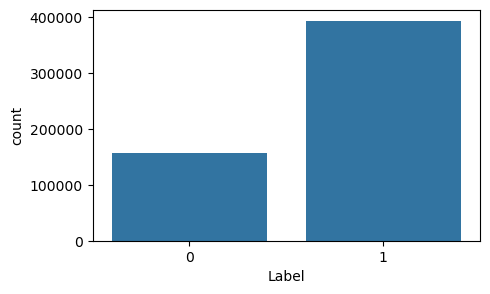

In [35]:
plt.figure(figsize=(5, 3))
sns.countplot(x=df['Label'])
plt.show()

In [37]:
# Visualizing the Dataframe using Pairplot
#plt.figure(figsize=(3, 2), dpi=200)
#sns.pairplot(df, hue="Label");
#plt.show()

In [39]:
X = df.drop(columns=['Label','URL','domain'])
y = df['Label']

In [41]:
X.head()

,levenshtein_distance,max_cosine_sim,url_length,num_digits,num_special_chars,num_subdomains,has_https
0,7,0.028777,225,58,24,6,0
1,6,0.036444,81,1,12,5,0
2,9,0.026586,177,47,19,7,0
3,6,0.185204,60,0,8,6,0
4,10,0.047676,116,21,12,1,0


In [43]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int32

In [45]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [49]:
scaler = StandardScaler()
 # Scale the X_train & X_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
from sklearn.preprocessing import  PolynomialFeatures


In [53]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [55]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Polynomial Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier()
 }

In [57]:
# Iterate over each model in the dictionary
for name, model in models.items():  
    print(f"\n\033[1m{name}:\033[0m")
    # Check if the model is Polynomial Regression (requires polynomial features)
    if name == "Polynomial Regression":
        model.fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
    else:
        model.fit(X_train, y_train)  # Train model with standardized training data
        y_pred = model.predict(X_test)  # Predict using standardized test data
    
    # Calculating the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy:{accuracy}")
    
    # Printing detailed classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Logistic Regression:
Accuracy:0.7760369893934613
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.37      0.48     46637
           1       0.79      0.94      0.86    118167

    accuracy                           0.78    164804
   macro avg       0.74      0.65      0.67    164804
weighted avg       0.76      0.78      0.75    164804


Polynomial Regression:
Accuracy:0.8098953908885707
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.44      0.57     46637
           1       0.81      0.96      0.88    118167

    accuracy                           0.81    164804
   macro avg       0.81      0.70      0.72    164804
weighted avg       0.81      0.81      0.79    164804


K-Nearest Neighbors:
Accuracy:0.8654887017305405
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75     46637
           1    

C:\Users\mouni\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:0.8082449455110313
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.48      0.59     46637
           1       0.82      0.94      0.88    118167

    accuracy                           0.81    164804
   macro avg       0.79      0.71      0.73    164804
weighted avg       0.80      0.81      0.79    164804


Gradient Boosting:
Accuracy:0.8338996626295478
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.54      0.65     46637
           1       0.84      0.95      0.89    118167

    accuracy                           0.83    164804
   macro avg       0.82      0.75      0.77    164804
weighted avg       0.83      0.83      0.82    164804


XGBoost:
Accuracy:0.8585046479454382
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72     46637
           1       0.87      0.95      0.91    118167
